In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
SECONDS_IN_DAY = 24*60*60
NUM_SAMPLES=1000

In [3]:
spark = (SparkSession
    .builder
    .appName("Feature Eng Cyclical")
    .getOrCreate()
)

In [4]:
def rand_times(n):
    rand_seconds = np.random.randint(0, SECONDS_IN_DAY, n)
    return spark.createDataFrame(pd.DataFrame(rand_seconds, columns=["seconds"])).orderBy("seconds")

df = rand_times(NUM_SAMPLES)

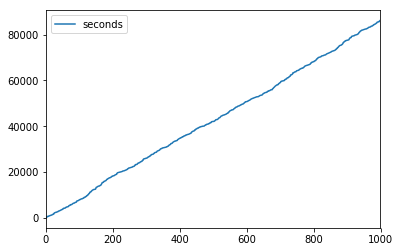

In [5]:
df.toPandas().plot()

In [6]:
df = (df
    .withColumn("sin", sin(2*np.pi*df.seconds/SECONDS_IN_DAY))
    .withColumn("cos", cos(2*np.pi*df.seconds/SECONDS_IN_DAY))
    .drop(df.seconds)
)

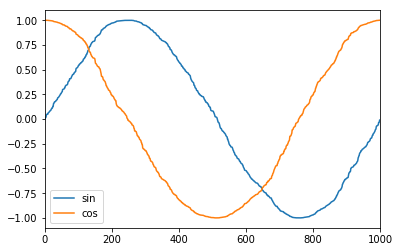

In [7]:
df.toPandas().plot()

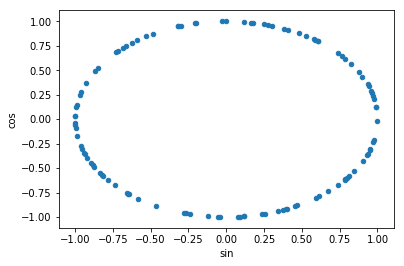

In [8]:
df.sample(fraction=0.1).toPandas().plot.scatter("sin", "cos")

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

CLUSTERS=6

assembler = VectorAssembler(inputCols=["sin", "cos"], outputCol="features")
kmeans = KMeans(k=CLUSTERS)

p = Pipeline(stages=[assembler, kmeans])

model = p.fit(df)
predictions = model.transform(df)

predictions.cache()

DataFrame[sin: double, cos: double, features: vector, prediction: int]

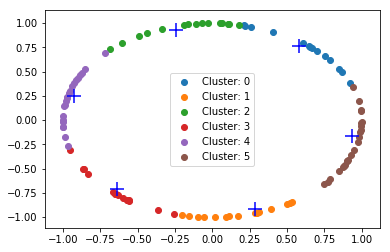

In [10]:
samples = predictions.sample(fraction=0.1)

for i in range(CLUSTERS):
    p_i = samples.filter(samples.prediction == i).select("sin", "cos").toPandas()
    plt.scatter(p_i.sin, p_i.cos, label="Cluster: %d" % i)

kmeans_model = model.stages[-1]
centroids = kmeans_model.clusterCenters()
centroids_rotated = zip(*centroids[::-1])        
plt.scatter(centroids_rotated[0], centroids_rotated[1], c="b", s=200, marker="+")

plt.legend()
plt.show()

In [12]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance: " + str(silhouette))


Silhouette with squared euclidean distance: 0.681131717374
